# Sparse Gaussian process regression

Implementation of Rossi et al. (2021).

In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '5'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [5]


In [2]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from distrax._src.distributions.distribution import Distribution

import os
import sys

from blackjax import normal_random_walk, elliptical_slice
from blackjax.diagnostics import potential_scale_reduction, effective_sample_size

from jaxtyping import Array

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../')))

from bamojax.base import Node, Model
from bamojax.sampling import gibbs_sampler, smc_inference_loop
from bamojax.more_distributions import GaussianProcessFactory, RBF, Zero, AscendingDistribution

print('Python version:       ', sys.version)
print('Jax version:          ', jax.__version__)
print('BlackJax version:     ', blackjax.__version__)
print('Distrax version:      ', dx.__version__)
print('Jax default backend:  ', jax.default_backend())
print('Jax devices:          ', jax.devices())

Python version:        3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:           0.4.35
BlackJax version:      1.2.4
Distrax version:       0.1.5
Jax default backend:   gpu
Jax devices:           [CudaDevice(id=0)]


## Data generation

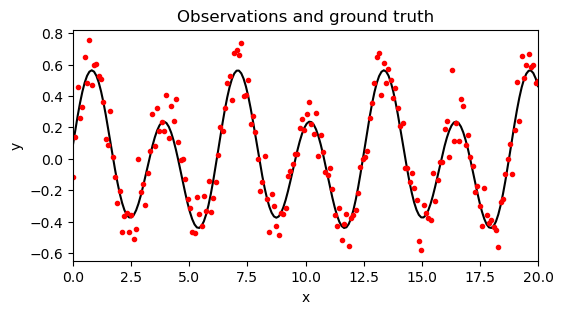

In [3]:
key = jrnd.PRNGKey(42)
key, subkey = jrnd.split(key)

sigma = 0.1
n = 200
x = jnp.linspace(0, 20, n)[:, jnp.newaxis]

f_true = 0.4*jnp.sin(2*x) + 0.1*jnp.cos(x-0.4) + 0.1*jnp.sin(x)
y = f_true.squeeze() + sigma*jrnd.normal(subkey, shape=(n,))

plt.figure(figsize=(6, 3))
plt.plot(x, f_true, color='k')
plt.plot(x, y, 'r.')
plt.xlim([0., 20.])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Observations and ground truth');

Set up the BaMoJax implementation:

[TODO] Can we (elegantly) make this independent of specific covariance function choices?


In [4]:
def FITC_link_fn(x, z, u, scale, **hyperparameters):
    r""" The FITC sparse GP interpretation.

    In FITC, the actual f(x_i) are assumed to be independent given u. We then have

    y_i ~ N(mu_i, sigma^2_i), with

    mu_i = K(x_i, z) K(z,z)^-1 u  

    and
    
    sigma^2_i K(x_i, x_i) - Kx_i, z) K(z,z)^-1 K(Z, x_i)
    
    """

    cov_params = dict(**hyperparameters)
    tau = hyperparameters['variance']
    K_xz = cov_fn(cov_params, x, z)
    K_zz = cov_fn(cov_params, z, z)
    mean = jnp.dot(K_xz, jnp.linalg.solve(K_zz, u))
    fitc_cov = tau*jnp.ones(n,) - jnp.diag(jnp.dot(K_xz, jnp.linalg.solve(K_zz, K_xz.T)))

    return dict(loc=mean, scale=fitc_cov + scale)

#

cov_fn = RBF()  # GP covariance function
m = 30  # number of inducing pts


BSGP = Model('Bayesian Sparse Gaussian process', verbose=True)
lengthscale = BSGP.add_node(name='lengthscale', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
variance = BSGP.add_node(name='variance', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
obs_noise = BSGP.add_node(name='obs_noise', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))

x_node = BSGP.add_node(name='x', observations=x) 
# We can try different priors on the locations of the inducing points. 
# z_node = BSGP.add_node(name='z', distribution=dx.Uniform(low=0*jnp.ones(m, ), high=20*jnp.ones(m, )))
z_node = BSGP.add_node(name='z', distribution=AscendingDistribution(min_u=0.0, max_u=20.0, num_el=m))
u_node = BSGP.add_node(name='u', distribution=GaussianProcessFactory(mean_fn=Zero(), cov_fn=cov_fn), 
                       parents=dict(input=z_node, 
                                    lengthscale=lengthscale, 
                                    variance=variance))
y_node = BSGP.add_node(name='y', 
                       distribution=dx.Normal, 
                       observations=y, 
                       parents=dict(x=x_node, 
                                    z=z_node,
                                    u=u_node,                                    
                                    scale=obs_noise, 
                                    lengthscale=lengthscale,
                                    variance=variance), 
                       link_fn=FITC_link_fn)

BSGP.print_gibbs()

Adding node (lengthscale)
Adding node (variance)
Adding node (obs_noise)
Adding node (x)
Adding node (z)
Adding node (u)
Add edge (z) -> (u)
Add edge (lengthscale) -> (u)
Add edge (variance) -> (u)
Adding node (y)
Add edge (x) -> (y)
Add edge (z) -> (y)
Add edge (u) -> (y)
Add edge (obs_noise) -> (y)
Add edge (lengthscale) -> (y)
Add edge (variance) -> (y)
Gibbs structure:
z                   : p(u | lengthscale, variance, z) p(y | obs_noise, x, u, z, lengthscale, variance) p(z)
lengthscale         : p(u | lengthscale, variance, z) p(y | obs_noise, x, u, z, lengthscale, variance) p(lengthscale)
variance            : p(u | lengthscale, variance, z) p(y | obs_noise, x, variance, z, lengthscale, u) p(variance)
u                   : p(y | obs_noise, x, u, z, lengthscale, variance) p(u | lengthscale, variance, z)
obs_noise           : p(y | obs_noise, x, u, z, lengthscale, variance) p(obs_noise)


## SMC for a Bayesian sparse GP

In [ ]:
%%time

num_mcmc_steps = 100
num_particles = 1_000

step_fns = dict(lengthscale=normal_random_walk,
                variance=normal_random_walk,
                obs_noise=normal_random_walk,
                z=normal_random_walk,
                u=elliptical_slice)

step_fn_params = dict(lengthscale=dict(sigma=0.2),
                      variance=dict(sigma=0.2),
                      obs_noise=dict(sigma=0.01),
                      z=dict(sigma=0.01*jnp.eye(m)),
                      u=dict(implied_mvn_prior=True, name='elliptical_slice'))

gibbs = gibbs_sampler(BSGP, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)

final_state, lml, n_iter, final_info = smc_inference_loop(subkey, model=BSGP, kernel=gibbs, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

for node in ['lengthscale', 'variance', 'obs_noise', 'z']:
    print(f'Acceptance rate for {node}: {jnp.mean(final_info.update_info[node].is_accepted):0.3f}')

print('log marginal likelhood:', lml)
print('number of SMC iterations:', n_iter)

Acceptance rate for lengthscale: 0.412
Acceptance rate for variance: 0.933
Acceptance rate for obs_noise: 0.515
Acceptance rate for z: 0.278
log marginal likelhood: 109.95738914191628
number of SMC iterations: 36
CPU times: user 22min 32s, sys: 5.05 s, total: 22min 37s
Wall time: 22min 39s


* This is very slow and the duration seems variable, but it works! 
* The running time is greatly affected by the stepsize of $z$:
  * Too small, and its acceptance rate is decent, but exploration takes long and hence many SMC iterations are required.
  * Too large, and few proposals are accepted, reducing the effective sample size.
* Would smarter proposals (MALA / NUTS) be worthwhile?

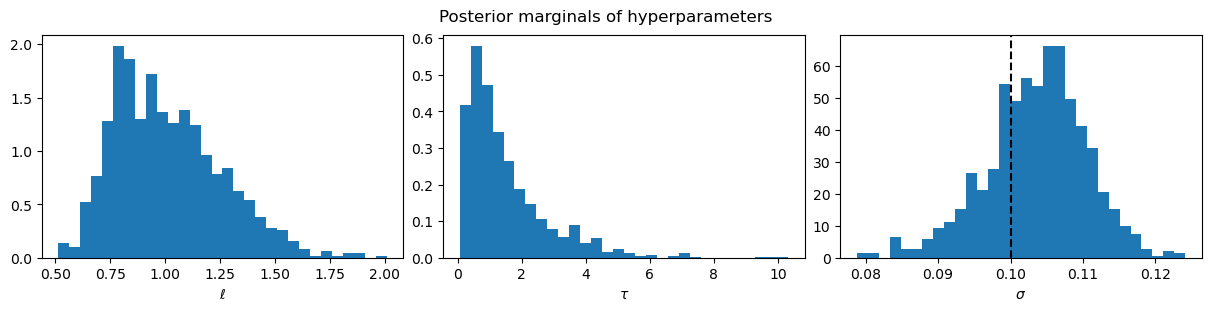

In [9]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3), constrained_layout=True)
axes[0].hist(final_state.particles['lengthscale'].flatten(), bins=30, density=True)
axes[0].set_xlabel(r'$\ell$')
axes[1].hist(final_state.particles['variance'].flatten(), bins=30, density=True)
axes[1].set_xlabel(r'$\tau$')
axes[2].hist(final_state.particles['obs_noise'].flatten(), bins=30, density=True)
axes[2].set_xlabel(r'$\sigma$')
axes[2].axvline(x=sigma, color='k', ls='--')

plt.suptitle('Posterior marginals of hyperparameters');

Sample from $p(f\mid X, Z, y, u, \theta)$.

We can easily replace $x$ by $x^*$ for extrapolation beyond the training range.

In [10]:
def fitc_wrapper(k, particle):
    gauss_params = FITC_link_fn(x, particle['z'].flatten(), particle['u'].flatten(), scale=0.0, lengthscale=particle['lengthscale'], variance=particle['variance'])
    return dx.Normal(**gauss_params).sample(seed=k)

#
key, subkey = jrnd.split(key)
keys = jrnd.split(subkey, num_particles)
f_pred = jax.vmap(fitc_wrapper)(keys, final_state.particles)

Visualize approximation:

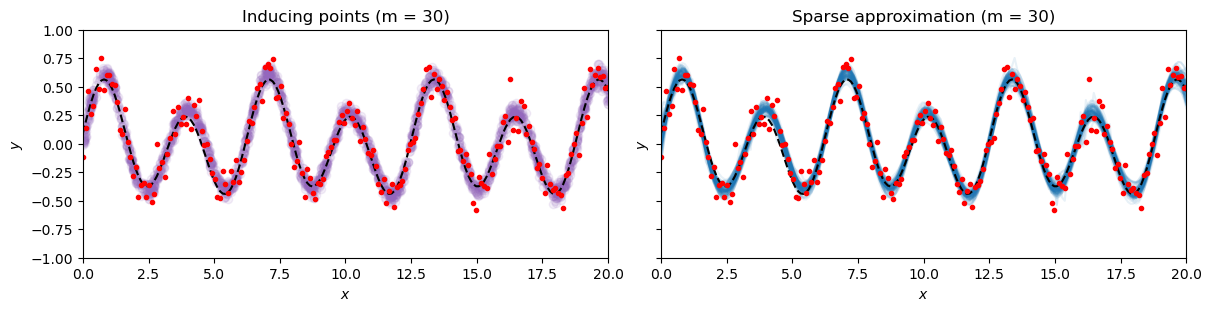

In [13]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), sharex=True, sharey=True, constrained_layout=True)

num_show = 100
key, subkey = jrnd.split(key)
inds = jrnd.randint(subkey, shape=(num_show,), minval=0, maxval=num_particles)

for ix in inds:
    z_ix = final_state.particles['z'][ix].flatten()
    u_ix = final_state.particles['u'][ix].flatten()
    sorted_ix = jnp.argsort(z_ix)
    axes[0].plot(z_ix[sorted_ix], u_ix[sorted_ix], ls='None', marker='o', alpha=0.1, color='tab:purple')
    axes[1].plot(x.flatten(), f_pred[ix, :].flatten(), alpha=0.1, color='tab:blue')
    
for ax in axes:
    ax.plot(x, f_true, color='k', ls='--', label=r'True $f$')
    ax.plot(x, y, 'r.', label='data')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_xlim([0.0, 20.0])
    ax.set_ylim([-1, 1])

axes[0].set_title(f'Inducing points (m = {m})')
axes[1].set_title(f'Sparse approximation (m = {m})');

Although we save memory by using inducing points, we trade it versus additional inference time (and accuracy).